# History Matching for L96
Author : Homer Durand

Date : 26-07-21

### Loading libs

In [1]:
mogp_dir <- "/home/homer/Documents/Locean/HistoryMatching/mogp-emulator" #mogp_emulator lib

setwd('/home/homer/Documents/Locean/HistoryMatching/dev_ExeterUQ_MOGP/') #setting working directory to dev_ExeterUQ_MOGP and load libs

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd('/home/homer/Documents/Locean/HistoryMatching/libs/') #setting wd to libs and load personnal libs for preprocessing and refocussing
source("../libs/unPreProc.R")

setwd('/home/homer/Documents/Locean/AMIP/') #setting wd to libs and load personnal libs for preprocessing and refocussing
L96_amip <- import("L96_amip")
data_generation <- import("data_generation")
setwd('/home/homer/Documents/Locean/HistoryMatching/libs/') #setting wd to libs and load personnal libs for preprocessing and refocussing
np <- import("numpy")
smt <- import("smt")
sklearn <- import("sklearn")

packages <- c("FactoMineR", "factoextra", "corrplot", 'kernlab', 'pca3d', 'BBmisc', 'comprehenr', 'caret', "future.apply", 'tgp', 'ANN2', 'ramify')
# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.88 loaded

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
Newinit = l96_two$X
Newinit

[1]  4.42757870 -1.95495041  4.02579735  7.58204632  1.62852532  0.39357305
 [7] -0.27120997  0.50364081  1.39288414  7.19375682  4.24944906  4.31670564
[13] 10.65758988  3.57441467  0.28612741  1.59561931  5.81580349 -0.01928225
[19]  9.29077971  2.98459204  0.23466043 -1.10569887  5.99612019  5.39444981
[25]  1.73690034  0.13736713  1.49172092 -1.82474446 -0.34535066 10.71303763
[31]  1.52854734 -1.29510637  0.11986749  2.52317066  4.46499941 10.24747885

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))
n_iter <- 10 
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0)))

   user  system elapsed 
  1.513   0.008   1.526 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [10]:
n_samples <- 30

In [11]:
space <- skSpace$Space(list(c(-2, 2), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

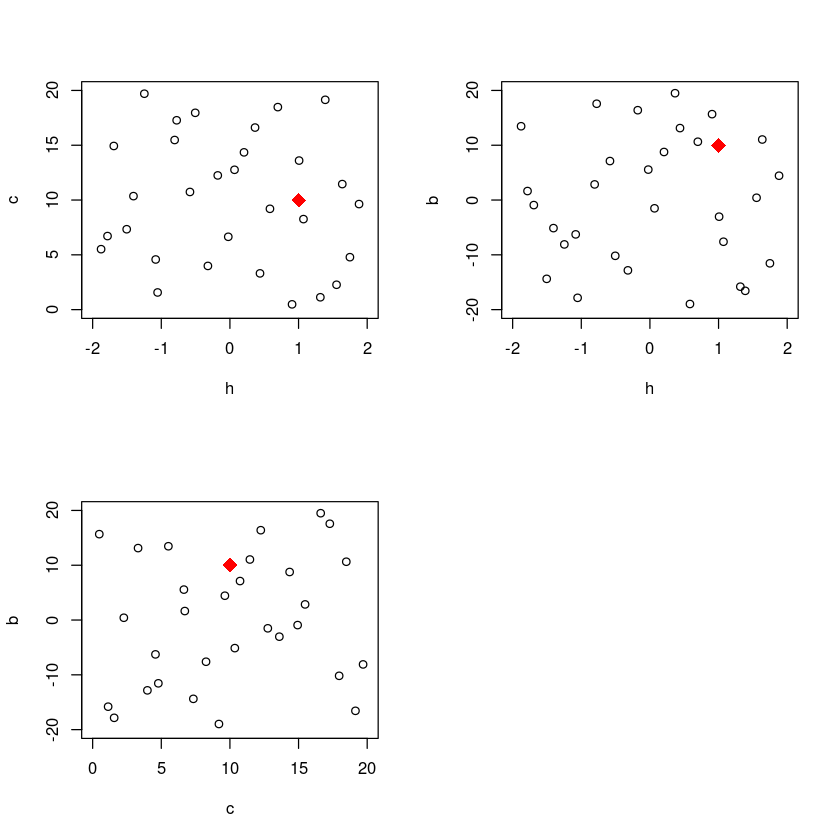

In [12]:
par(mfrow=c(2,2))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [13]:
extract_metrics_AMIP <- function(p, n_iter, dt, X_hist) {
    initX <- as.matrix(X_hist[1,])
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=10, c=p[[2]], b=p[[3]])
    l96_mip$iterate_AMIP(X_hist, n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0)))
}

In [14]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

In [15]:
k <- 0 # Select k in K for tunning 
metrics_index_k <- (k*65+1):((k+1)*65)

In [16]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'c', 'b')


metrics_k_wave1 <- data.frame(t(metrics_wave1)[, metrics_index_k])
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_k_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.01201163,-0.3353458,0.2776930,0,-0.006420097,-0.006302724,-0.006309862,-0.006309524,-0.006308370,-0.006309555,⋯,8.040896e-05,8.060961e-05,7.764213e-05,0.0000799824,8.081122e-05,7.783269e-05,8.018136e-05,7.502619e-05,7.721373e-05,7.967611e-05
2,0.34905567,0.8478337,0.5320322,0,0.105538421,0.068697174,0.084799267,0.105912561,0.090199820,0.055292361,⋯,4.200927e-02,2.072397e-02,6.217308e-03,0.0177629503,3.367242e-02,1.393381e-02,1.070093e-02,2.560529e-02,1.471335e-02,4.267811e-02
3,0.50403953,0.3601328,-0.1518286,0,-0.006445521,0.237981995,-0.007404240,0.186781565,-0.014454777,0.215586632,⋯,3.415417e-02,2.000427e-02,2.256316e-02,0.0055672893,1.079500e-01,8.928603e-03,9.770488e-02,2.672015e-02,-6.281238e-03,1.157048e-01
4,-0.08859503,0.2247366,0.8196509,0,0.002876718,-0.045517209,0.003144312,-0.035722238,0.002147645,-0.039496303,⋯,9.518025e-04,6.397925e-04,7.712179e-04,0.0001814227,3.457189e-03,4.088819e-04,3.217118e-03,8.615864e-04,-1.074986e-04,3.813564e-03
5,-0.93853929,-0.4483700,0.6732339,0,-0.022457223,-0.094208743,-0.013564450,-0.057858226,-0.028031658,-0.088548652,⋯,8.612916e-02,2.743404e-03,3.030475e-02,0.0159979632,1.194932e-01,7.985882e-03,3.803280e-02,8.717307e-02,2.249705e-03,1.051677e-01
6,-0.40272438,0.5477225,0.1426025,0,-0.011566117,-0.221381152,-0.010322716,-0.182587973,-0.013466155,-0.196105155,⋯,2.254414e-02,1.924048e-02,1.833913e-02,0.0087921071,8.574896e-02,1.362513e-02,8.126697e-02,1.866998e-02,3.380719e-03,9.326263e-02


### Training emulator

In [17]:
cands <- names(tData)[1:3]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_k_wave1), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0324866889484487 using h"
[1] "Max reduction is 0.0080462388123647 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + b + I(b * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.301661 -0.043256  0.003435  0.036234  0.284406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.004889   0.018315  -0.267   0.7916    
h            0.159587   0.032470   4.915 4.21e-05 ***
b            0.081021   0.031912   2.539   0.0174 *  
I(b * h)     0.013509   0.062711   0.215   0.8311    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1003 on 26 degrees of freedom
Multiple R-squared:  0.5452,	Adjusted R-squared:  0.4928 
F-statistic: 10.39 on 3 and 26 DF,  p-value: 0.0001132

[1] "Max reduction is 0.0945718566703141 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h, data = tData)

Residuals:
      Min        1Q

We can use Leave One Out to verify if our GPs fit our metrics correctly.

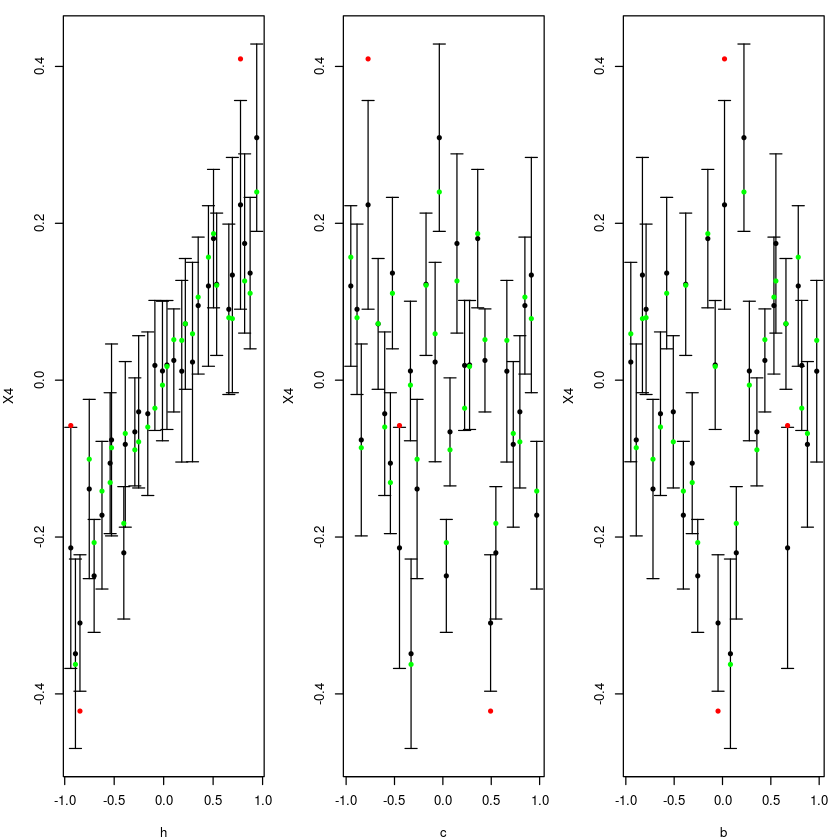

In [18]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 4, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [19]:
tDisc <- rep(0, ncol(metrics_k_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_k_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations[metrics_index_k]) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [20]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 68.433  23.946  18.287 

In [21]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h c   b
1 0.5 0 0.5


In [22]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.32314

The first wave of tuning allowed us to reject approximately 70% of the parameters space.

### Layout of NROY space

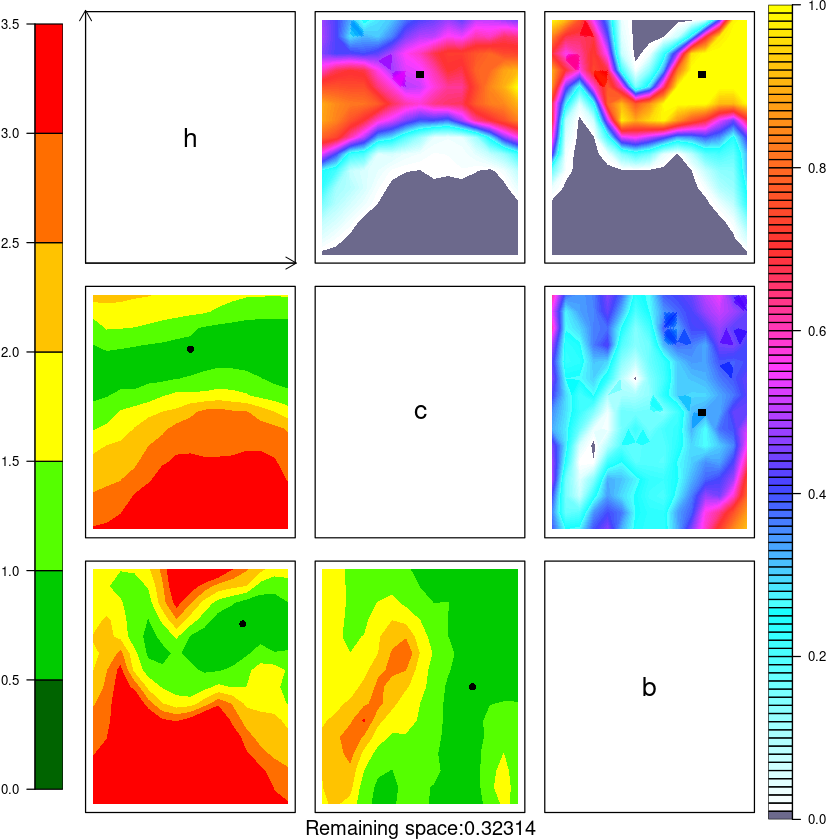

In [23]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

In [24]:
n <- ceiling(n_samples*1.3/scoreNROY1)

In [25]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [26]:
imp_em1_wave2 <- ImplausibilityMOGP(NewData=inputs_wave2_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_temp_wave2 <- which(rowSums(imp_em1_wave2 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

In [27]:
input_wave2_scaled <- inputs_wave2_scaled_temp[sample(NROY_temp_wave2, n_samples),]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

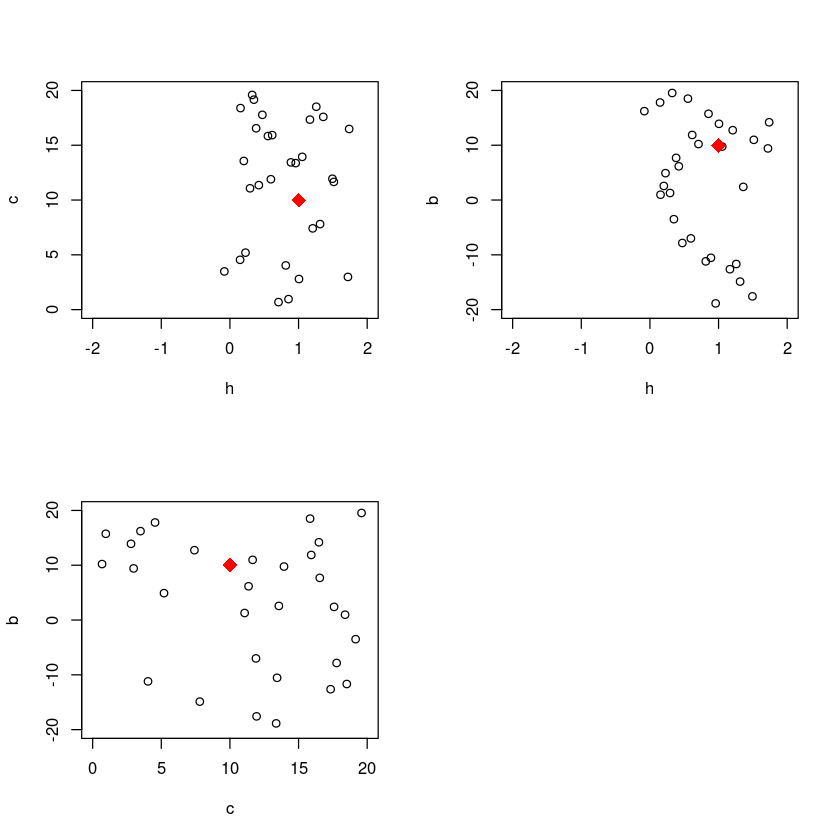

In [28]:
par(mfrow=c(2,2))
plot(input_wave2[,1], input_wave2[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,1], input_wave2[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,2], input_wave2[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [29]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics_AMIP(input_wave2[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [30]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'c', 'b')


metrics_k_wave2 <- data.frame(t(metrics_wave2)[, metrics_index_k])
N = nrow(metrics_k_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_k_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.30816149,0.5925188,0.5937913,0,0.089008914,0.05858245,0.07819954,0.07954210,0.0774363811,0.05822396,⋯,0.0317875468,0.0151309547,0.005492177,0.0134848885,0.0266837632,0.0112746184,0.0061534153,0.0218404394,0.0120869538,0.0324829810
2,0.47898611,0.3368370,-0.9430740,0,0.008322492,0.03848169,0.02426575,0.03526670,-0.0009496187,0.05471503,⋯,0.0194624869,-0.0017612744,0.009368325,0.0005174600,0.0191974929,-0.0022632906,0.0098715419,0.0313769952,-0.0020741520,0.0257185804
3,0.60307772,-0.2584979,0.6371993,0,0.081053903,0.08211085,0.10721923,0.11886260,0.0982116661,0.09258104,⋯,0.0721690980,0.0247852110,0.008585876,0.0142218815,0.0593043652,0.0231312732,0.0018707917,0.0859753578,0.0258245576,0.0541553102
4,0.35383260,-0.9313999,0.5106046,0,0.169666629,0.11486327,0.14099488,0.11716610,0.1096216674,0.14253485,⋯,0.0366935900,0.0155637599,0.014684749,0.0245716540,0.0134550930,0.0133850073,0.0126256422,0.0253129990,0.0245317377,0.0357628052
5,-0.04050533,-0.6514634,0.8109717,0,-0.018933013,-0.02262419,-0.01918902,-0.02236227,-0.0183315056,-0.02237260,⋯,0.0005172577,0.0006127441,0.000436400,0.0005928954,0.0008055012,0.0005111678,0.0007866996,0.0003877175,0.0005122927,0.0008039168
6,0.40687254,-0.5966457,-0.5596679,0,-0.035569749,0.10743538,-0.01220670,0.07366640,-0.0139271922,0.09123871,⋯,0.0175203244,0.0012261379,0.013239613,0.0037391500,0.0345825808,0.0025526669,0.0227297295,0.0280559044,0.0026845880,0.0385499849


### Training emulator

In [31]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00621351723952729 using b"
[1] "Max reduction is 0.00365804724392039 using b"
[1] "Max reduction is 0.00773890404412926 using h"
[1] "Max reduction is 0.00275588906005141 using b"
[1] "Max reduction is 0.0103524590886789 using b"
[1] "Max reduction is 0.00598426015358433 using h"
[1] "Max reduction is 0.00153857704141918 using b"
[1] "Max reduction is 0.000834840036115159 using Three Way Interactions with b"
[1] "Max reduction is 0.0027581812301155 using c"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ b + I(b^2) + I(b^3) + I(b^4) + I(b^5) + h + 
    I(h^2) + c + I(h * b) + I(c * b) + I(c * h) + I(b * h * b) + 
    I(b * c * b) + I(b * c * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040445 -0.012641  0.001514  0.011010  0.042722 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.04825    0.02577  -1.872 0.080775 .  
b             0.27965    0.

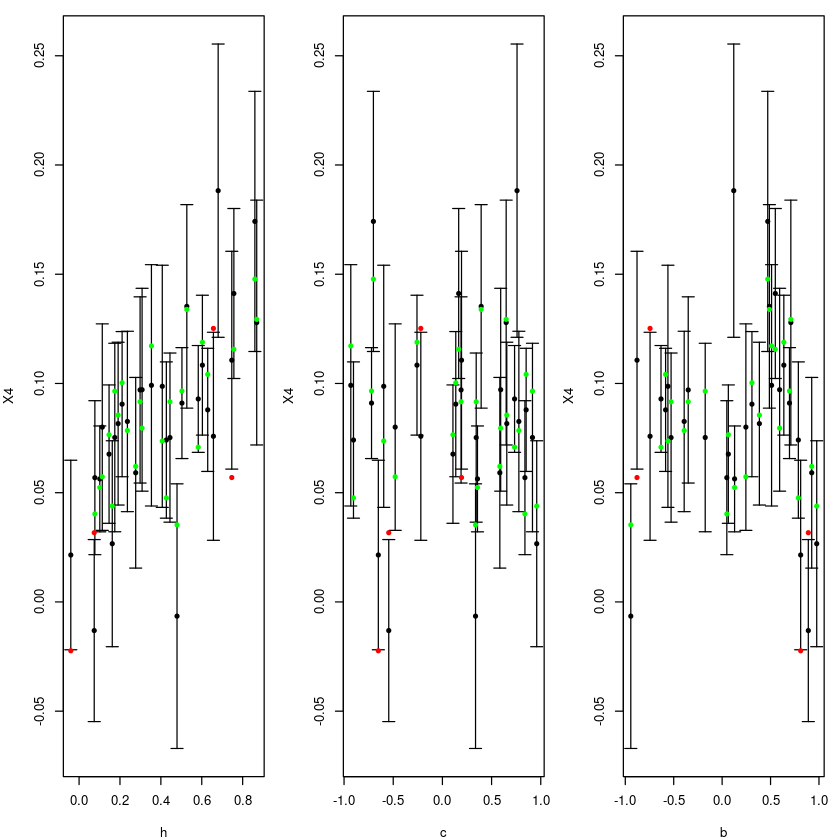

In [32]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [33]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 15.559   5.281   3.849 

Warning : Here we set valmax to 3 to generate a more steady NROY space

In [34]:
valmax = 3 #Set to 3 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [35]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

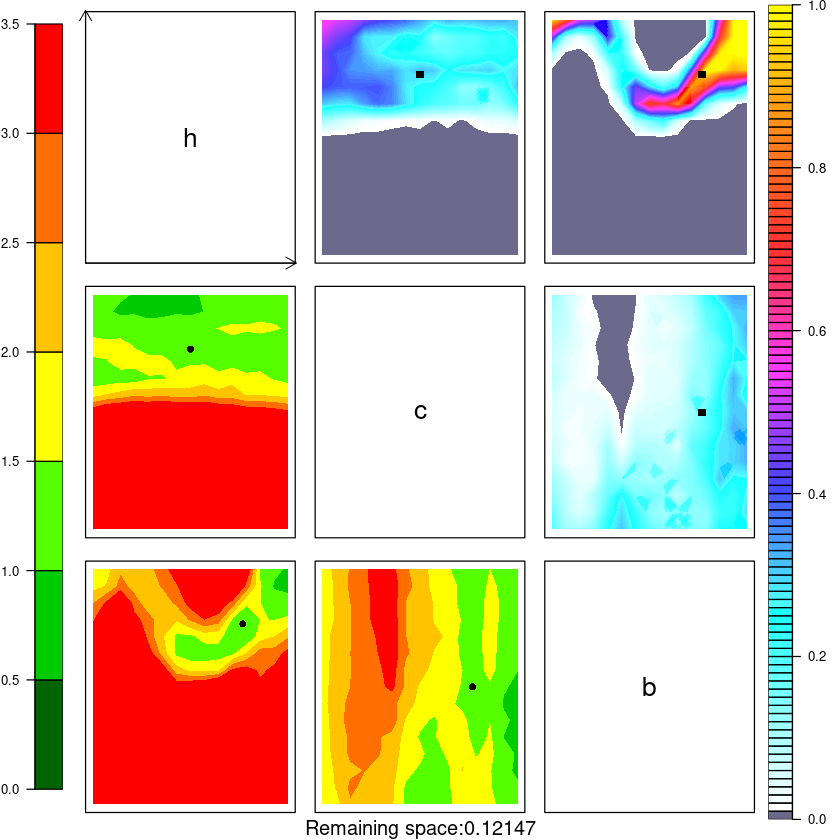

In [36]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [37]:
n <- ceiling(n_samples*1.3/scoreNROY2)

In [38]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [39]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

In [40]:
NROY_temp_wave3 <- sample(intersect(NROY_em1, NROY_em2), n_samples)

In [41]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

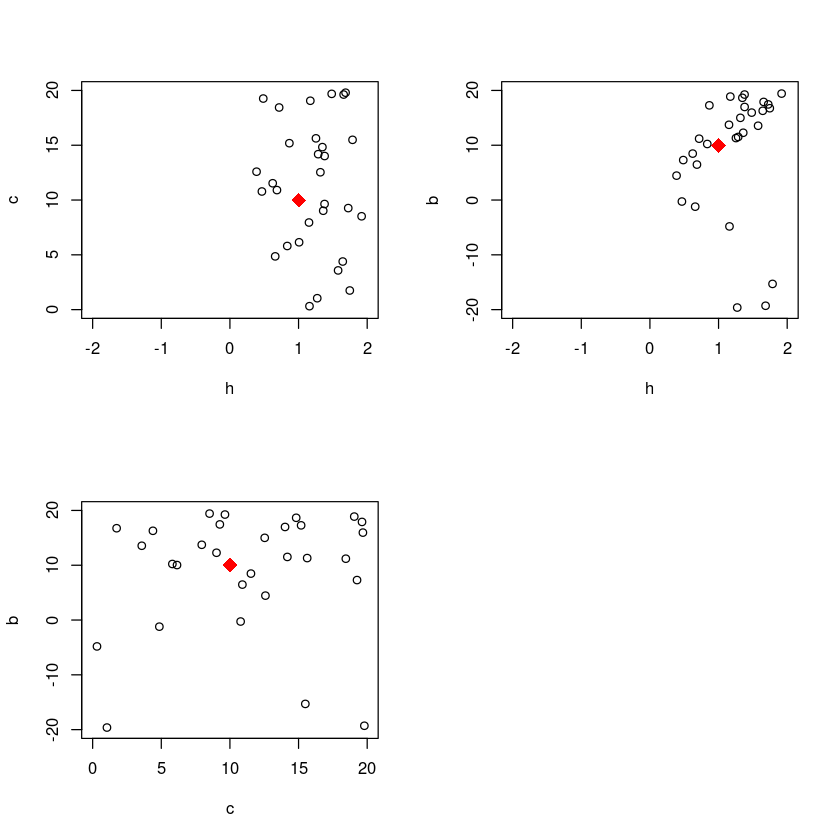

In [42]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [43]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [44]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0)
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6361160,-0.8958370,-0.9809546,0,-0.04987771,0.14262221,-0.03633996,0.11479022,-0.03483639,0.08544524,⋯,0.03613164,-0.003216544,0.006008568,-0.01753489,0.07070617,0.007402887,0.0251441658,0.02788907,-0.00401841,0.04082359
2,0.6590817,0.2534715,0.7500380,0,0.08324353,0.10018491,0.09938704,0.11712382,0.09458174,0.09009181,⋯,0.08121908,0.019601127,0.001863820,0.01232891,0.07782334,0.020784448,-0.0011822640,0.06632380,0.01833340,0.06594624
3,0.8219417,-0.5609695,0.8142387,0,0.09192376,0.13785008,0.09437366,0.08409675,0.07320507,0.10180310,⋯,0.09267958,0.015400367,0.009344770,0.02072895,0.09432158,0.024691828,-0.0018180152,0.09482925,0.03172369,0.07487514
4,0.6898005,0.4015890,0.8491575,0,0.07866709,0.08479339,0.10616095,0.08604640,0.09541002,0.10337540,⋯,0.06736127,0.017354706,0.002994479,0.01286893,0.07290940,0.019140116,-0.0002982799,0.06925052,0.01937430,0.06989001
5,0.5039931,-0.3854400,0.5016888,0,0.10583588,0.09766974,0.15972087,0.12492994,0.10788080,0.12275107,⋯,0.06260982,0.025542213,0.007733771,0.01727802,0.05924556,0.022806537,0.0047775620,0.05367237,0.02559065,0.05719191
6,0.5760718,-0.2051016,0.6865822,0,0.12141940,0.08512143,0.07246731,0.12164208,0.06400482,0.09906006,⋯,0.06582241,0.019113907,0.008904988,0.01817343,0.05361340,0.019471900,0.0016925902,0.08890716,0.02480818,0.05721282


### Training emulator

In [45]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00158888508108614 using h"
[1] "Max reduction is 0.00228815909787975 using b"
[1] "Max reduction is 0.00921096758196279 using b"
[1] "Max reduction is 0.00177271542303102 using b"
[1] "Max reduction is 0.00140534334418664 using b"
[1] "Max reduction is 0.00225444137575741 using b"
[1] "Max reduction is 0.00170535030681391 using Three Way Interactions with b"
[1] "Max reduction is 0.00184484388346125 using c"
[1] "Max reduction is 0.000195445162559652 using h"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ h + I(h^2) + b + I(b^2) + I(b^3) + I(b^4) + 
    I(b^5) + c + I(b * h) + I(c * h) + I(c * b) + I(b * b * h) + 
    I(b * c * h) + I(b * c * b), data = tData)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0310178 -0.0073555 -0.0001405  0.0051841  0.0252704 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.04460    0.04752   0.939   0.3628   
h             0.4

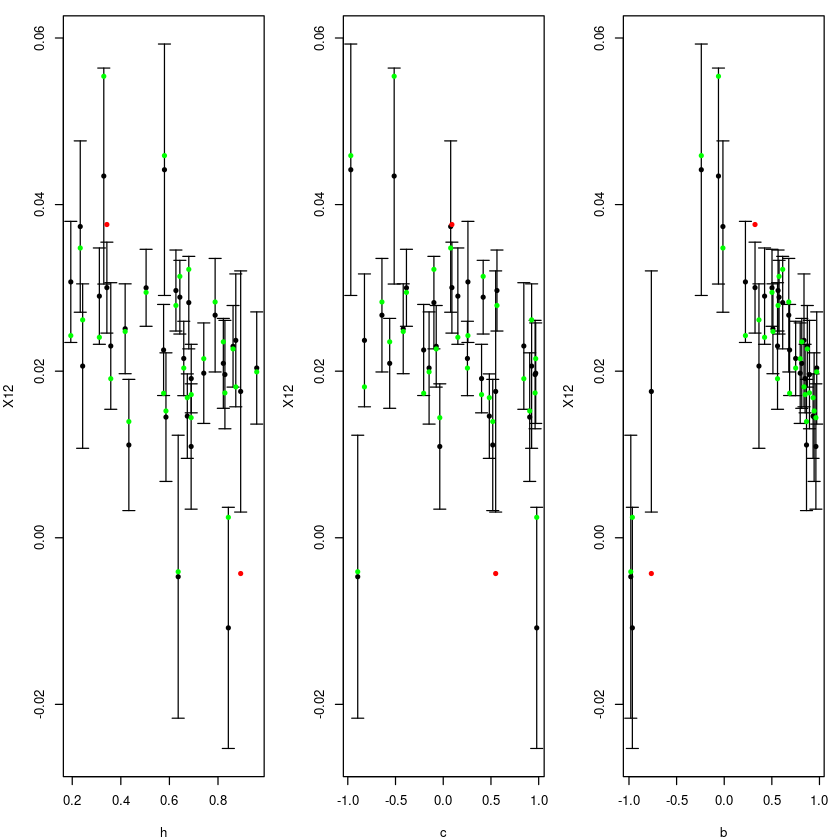

In [46]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [47]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 15.266   3.600   3.426 

In [59]:
valmax = 3 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [60]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

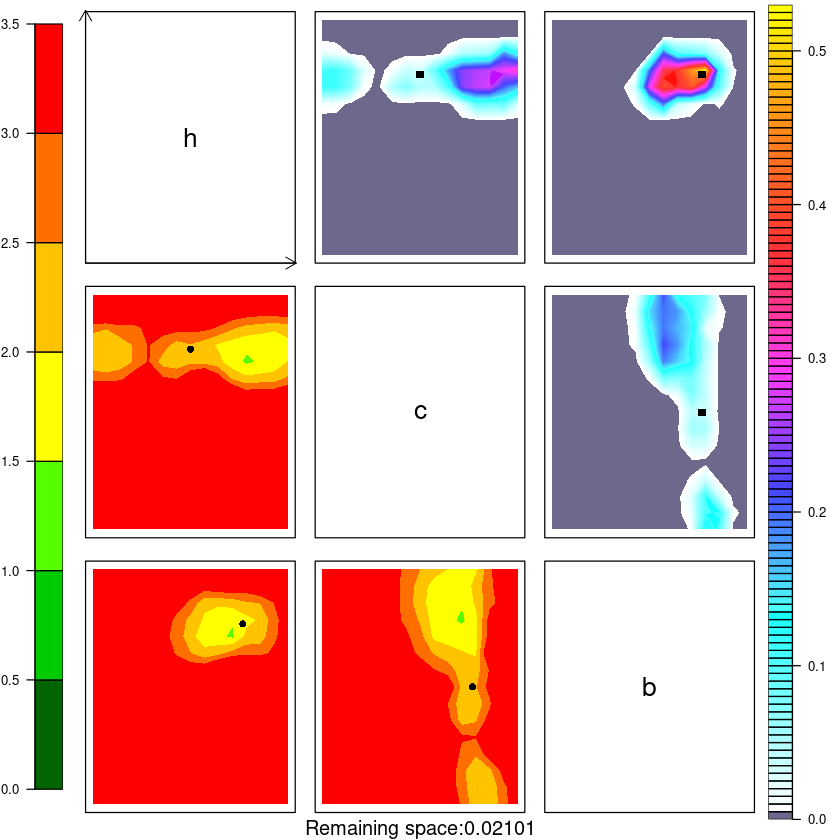

In [61]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [68]:
n <- ceiling(n_samples*4/scoreNROY3)

In [69]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [70]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

imp_em3 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em3 <- which(rowSums(imp_em3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)

In [71]:
inter12 <- intersect(NROY_em1, NROY_em2)
NROY_em1.2.3 <- intersect(inter12, NROY_em3)

In [72]:
length(NROY_em1.2.3)

[1] 32

In [73]:
NROY_temp_wave4 <- sample(NROY_em1.2.3, n_samples)

In [74]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

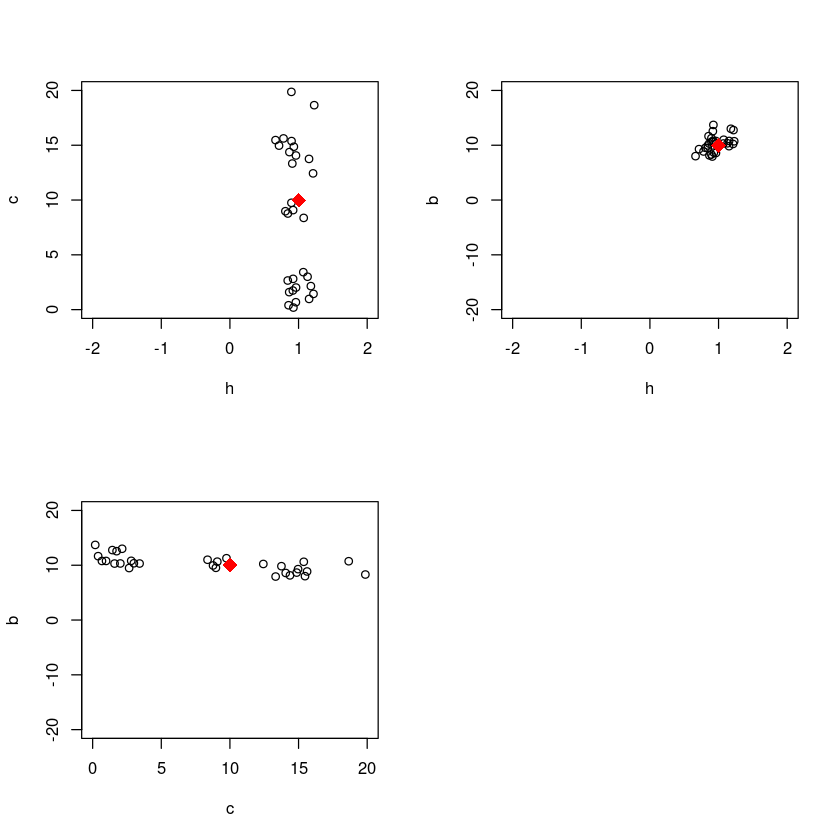

In [75]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [78]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

### Training emulator

In [ ]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

In [ ]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)